In [ ]:
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import html
import random
import numpy as np
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/CS7650/Final Project")

Mounted at /content/drive


In [ ]:
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
train = pd.read_csv('train.tsv', sep='\t', header=None)
test = pd.read_csv('test.tsv', sep='\t', header=None)
valid = pd.read_csv('valid.tsv', sep='\t', header=None)

In [ ]:
train = train.iloc[:, 1:3]
train.columns = ['label', 'data']

valid = valid.iloc[:, 1:3]
valid.columns = ['label', 'data']

label_mapping = {
    'true': 0,
    'mostly-true': 1,
    'half-true': 2,
    'barely-true': 3,
    'false': 4,
    'pants-fire': 5
}

train['target'] = train['label'].map(label_mapping)
valid['target'] = valid['label'].map(label_mapping)

train

,label,data,target
0,false,Says the Annies List political group supports ...,4
1,half-true,When did the decline of coal start? It started...,2
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",1
3,false,Health care reform legislation is likely to ma...,4
4,half-true,The economic turnaround started at the end of ...,2
...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,1
10236,mostly-true,Democrats have now become the party of the [At...,1
10237,half-true,Says an alternative to Social Security that op...,2
10238,false,On lifting the U.S. Cuban embargo and allowing...,4


In [ ]:
# Defining global constants
RANDOM_SEED = 42
PADDING_VALUE = 0
UNK_VALUE     = 1
BATCH_SIZE = 128

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))

In [ ]:
def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
train["tokenized"] = train['data'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
valid["tokenized"] = valid['data'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
id2label = dict(zip(train['target'], train['label']))
id2label = {k: id2label[k] for k in id2label if isinstance(k, int)}
id2label = {k: id2label[k] for k in sorted(id2label)}
id2label

{0: 'true',
 1: 'mostly-true',
 2: 'half-true',
 3: 'barely-true',
 4: 'false',
 5: 'pants-fire'}

In [ ]:
def generate_vocab_map(df, cutoff=2):
    """
    This method takes a dataframe and builds a vocabulary to unique number map.
    It uses the cutoff argument to remove rare words occurring <= cutoff times.
    "" and "UNK" are reserved tokens in our vocab that will be useful later.
    You'll also find the Counter imported for you to be useful as well.

    Args:
        df (pandas.DataFrame) : The entire dataset this mapping is built from
        cutoff (int) : We exclude words from the vocab that appear less than or equal to cutoff

    Returns:
        vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
            unique integer ID. Only elements that appear > cutoff times appear in vocab.
        reversed_vocab (dict[int] = str) : A reversed version of vocab, which allows us to retrieve
            words given their unique integer ID. This map will allow us to "decode" integer
            sequences we'll encode using vocab!
    """
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None

    ## YOUR CODE STARTS HERE ##
    # hint: start by iterating over df["tokenized"]
    all_tokens = [token for tokens in df["tokenized"] for token in tokens]
    token_counts = Counter(all_tokens)

    for token, count in token_counts.items():
        if count > cutoff:
            vocab[token] = len(vocab)

    reversed_vocab = {index: token for token, index in vocab.items()}
    ## YOUR CODE ENDS HERE ##

    return vocab, reversed_vocab

In [ ]:
train_vocab, reverse_vocab = generate_vocab_map(train)

In [ ]:
class HeadlineDataset(Dataset):
    """
    This class takes a Pandas DataFrame and wraps in a Torch Dataset.
    Read more about Torch Datasets here:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self, vocab, df, max_length=200):
        """
        Initialize the class with appropriate instance variables. In this method, we
        STRONGLY recommend storing the dataframe itself as an instance variable, and
        keeping this method very simple. Leave processing to __getitem__.

        Args:
            vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
                unique integer ID. Only elements that appear > cutoff times appear in vocab.
            df (pandas.DataFrame) : The entire dataset this mapping is built from
            max_length (int) : The max length of a headline we'll allow in our dataset.

        Returns:
            None
        """

        ## YOUR CODE STARTS HERE - initialize parameters ##
        self.vocab = vocab
        self.df = df
        self.max_length = max_length
        ## YOUR CODE ENDS HERE ##

    def __len__(self):
        """
        This method returns the length of the underlying dataframe,
        Args:
            None
        Returns:
            df_len (int) : The length of the underlying dataframe
        """

        df_len = None

        ## YOUR CODE STARTS HERE ##
        df_len = len(self.df)
        ## YOUR CODE ENDS HERE ##

        return df_len

    def __getitem__(self, index: int):
        """
        This method converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
        using our vocab map created using generate_vocab_map. Restricts the encoded headline
        length to max_length.

        The purpose of this method is to convert the row - a list of words - into a corresponding
        list of numbers.

        i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
        this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]

        Args:
            index (int) : The index of the dataframe we want to retrieve.

        Returns:
            tokenized_word_tensor (torch.LongTensor) : A 1D tensor of type Long, that has each
                token in the dataframe mapped to a number. These numbers are retrieved from the
                vocab_map we created in generate_vocab_map.

                IMPORTANT: If we filtered out the word because it's infrequent (and it doesn't
                exist in the vocab) we need to replace it w/ the UNK token

            curr_label (int) : Label index of the class between 0 to len(num_classes) - 1 representing which
            class label does this data instance belong to
        """

        tokenized_word_tensor = None
        curr_label            = None

        ## YOUR CODE STARTS HERE ##
        row = self.df.iloc[index]
        tokenized_words = row['tokenized']
        curr_label = row['target']

        encoded_words = []
        for word in tokenized_words:
            encoded_words.append(self.vocab.get(word, self.vocab["UNK"]))

        if len(encoded_words) > self.max_length:
            encoded_words = encoded_words[:self.max_length]

        if len(encoded_words) < self.max_length:
            encoded_words = encoded_words + [self.vocab[""]] * (self.max_length - len(encoded_words))

        tokenized_word_tensor = torch.LongTensor(encoded_words)
        ## YOUR CODE ENDS HERE ##

        return tokenized_word_tensor, curr_label

In [ ]:
train_dataset = HeadlineDataset(train_vocab, train)
val_dataset   = HeadlineDataset(train_vocab, valid)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll define how our DataLoaders sample elements from the HeadlineDatasets
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [ ]:
def collate_fn(batch, padding_value=PADDING_VALUE):
    """
    This function is passed as a parameter to Torch DataSampler. collate_fn collects
    batched rows, in the form of tuples, from a DataLoader and applies some final
    pre-processing.

    Objective:
    In our case, we need to take the batched input array of 1D tokenized_word_tensors,
    and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors
    in a batch. We're moving from a Python array of tuples, to a padded 2D tensor.

    *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)

    Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html

    :param batch: PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)] of length BATCH_SIZE
    :param padding_value: int

    :return padded_tokens: 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    :return y_labels: 1D FloatTensor of shape (BATCH_SIZE)
    """

    padded_tokens, y_labels = None, None

    ## YOUR CODE STARTS HERE - take the input and target from batch, pad the tokens, convert batches to tensor ##
    tokenized_word_tensors = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    padded_tokens = pad_sequence(tokenized_word_tensors, batch_first=True, padding_value=padding_value)

    y_labels = torch.tensor(labels, dtype=torch.float32)
    ## YOUR CODE ENDS HERE ##

    return padded_tokens, y_labels

In [ ]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

for x, y in val_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([128, 200])
y: torch.Size([128])


In [ ]:
class NBOW(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 2 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    #
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        ## YOUR CODE STARTS HERE ##
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PADDING_VALUE)
        self.linear = nn.Linear(embedding_dim, num_classes, bias=False)
        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## Hint: Make sure to handle the case where x contains pad tokens. We don't want to consider them in our average.
        ## YOUR CODE STARTS HERE ##
        embeddings = self.embedding(x)

        mask = (x != PADDING_VALUE).unsqueeze(-1)  # Shape: (BATCH_SIZE, max_len, 1)

        embeddings_sum = torch.sum(embeddings * mask, dim=1)  # Shape: (BATCH_SIZE, embedding_dim)

        valid_tokens_count = mask.sum(dim=1).float()  # Shape: (BATCH_SIZE, 1)
        h_avg = embeddings_sum / valid_tokens_count  # Shape: (BATCH_SIZE, embedding_dim)

        logits = self.linear(h_avg)  # Shape: (BATCH_SIZE, num_classes)

        return logits
        ## YOUR CODE ENDS HERE ##

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight. Ensure you aren't recording gradients for this.
        Hint: Refer to nn.Parameter to do this.
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight = nn.Parameter(weight, requires_grad=False)
        ### YOUR CODE ENDS HERE ###
    def get_h_avg(self, x):
        '''
        This function returns the average of the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.embedding(x)

        mask = (x != PADDING_VALUE).unsqueeze(-1)

        embeddings_sum = torch.sum(embeddings * mask, dim=1)

        valid_tokens_count = mask.sum(dim=1).float()
        h_avg = embeddings_sum / valid_tokens_count

        return h_avg

In [ ]:
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)

    # Get the F1 score
    f1 = f1_score(y_true, y_predicted, average='macro')

    return accuracy, f1

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

def get_criterion(loss_type='ce'):
    criterion = None

    ## YOUR CODE STARTS HERE ##
    if loss_type == 'ce':
        criterion = nn.CrossEntropyLoss()
    ## YOUR CODE ENDS HERE ##

    return criterion

def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    optimizer = None

    ## YOUR CODE STARTS HERE ##
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ## YOUR CODE ENDS HERE ##

    return optimizer

In [ ]:
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x, y = x.to(device), y.to(device)
        y = y.long()
        forward = model(x)
        loss = criterion(forward, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x, y = x.to(device), y.to(device)
        y = y.long()
        forward = model(x)
        loss = criterion(forward, y)
        total_loss += loss.item()
        true.extend(y.tolist())
        pred.extend(torch.argmax(forward, dim=1).tolist())
    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

In [ ]:
def get_hyperparams_nbow():
  ### your hyper parameters
  learning_rate = 0.01
  epochs = 10
  embedding_dim = 5
  ###
  return learning_rate, epochs, embedding_dim

def get_nbow_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the NBOW model.
    """
    model = None
    # Define a model and return
    # YOUR CODE STARTS HERE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NBOW(vocab_size, embedding_dim)

    model.to(device)
    model.device = device
    # YOUR CODE ENDS HERE
    return model

In [ ]:
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_nbow = []
val_loss_over_time_nbow = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_nbow.append(train_loss)
    val_loss_over_time_nbow.append(val_loss)
save_checkpoint(nbow_model, 'nbow')

Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 44.74it/s]


Epoch 1 -- Train_Loss: 2.339963014423847 -- Val_Loss: 1.8095412037589333 -- Val_Accuracy: 0.20327102803738317 -- Val_F1: 0.1308682426958427


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 47.14it/s]


Epoch 2 -- Train_Loss: 1.7779666230082511 -- Val_Loss: 1.7787650390104814 -- Val_Accuracy: 0.20794392523364486 -- Val_F1: 0.1265744414872723


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 35.34it/s]


Epoch 3 -- Train_Loss: 1.7529622912406921 -- Val_Loss: 1.7461730892008 -- Val_Accuracy: 0.205607476635514 -- Val_F1: 0.15854243997039932


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 61.11it/s]


Epoch 4 -- Train_Loss: 1.7368257194757462 -- Val_Loss: 1.7644732757048174 -- Val_Accuracy: 0.2336448598130841 -- Val_F1: 0.15840698047204524


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 61.95it/s]


Epoch 5 -- Train_Loss: 1.7121813401579857 -- Val_Loss: 1.7763989947058938 -- Val_Accuracy: 0.23130841121495327 -- Val_F1: 0.15600479561848013


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 47.41it/s]


Epoch 6 -- Train_Loss: 1.677641934156418 -- Val_Loss: 1.7288419116627087 -- Val_Accuracy: 0.23442367601246106 -- Val_F1: 0.1821780904791778


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 56.77it/s]


Epoch 7 -- Train_Loss: 1.6300154358148575 -- Val_Loss: 1.7221965464678677 -- Val_Accuracy: 0.235202492211838 -- Val_F1: 0.199541883967702


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 60.37it/s]


Epoch 8 -- Train_Loss: 1.5770012795925141 -- Val_Loss: 1.7186847708441995 -- Val_Accuracy: 0.24221183800623053 -- Val_F1: 0.19967948534640712


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 44.08it/s]


Epoch 9 -- Train_Loss: 1.5192378401756286 -- Val_Loss: 1.7447725967927412 -- Val_Accuracy: 0.2546728971962617 -- Val_F1: 0.22215012600213194


Evaluating Model: 100%|██████████| 11/11 [00:00<00:00, 58.43it/s]


Epoch 10 -- Train_Loss: 1.4611245557665824 -- Val_Loss: 1.7748442129655317 -- Val_Accuracy: 0.2515576323987539 -- Val_F1: 0.22682969927905328
Checkpoint saved to /content/drive/MyDrive/CS7650/Final Project/model_weights/checkpoint_nbow_ce.pt


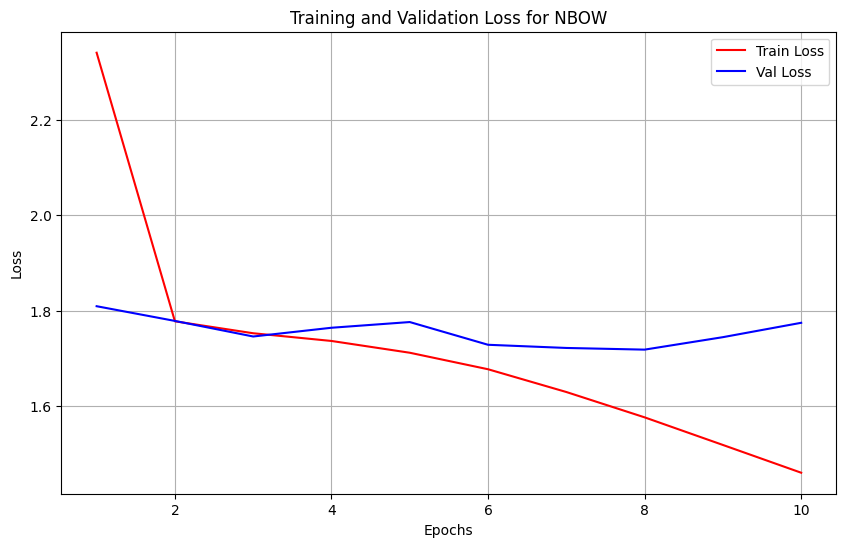

In [ ]:
plot_loss(train_loss_over_time_nbow, val_loss_over_time_nbow, 'NBOW')

In [ ]:
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-2-288c97cce947>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.2515576323987539
Final Validation F1-Score: 0.22682969927905328


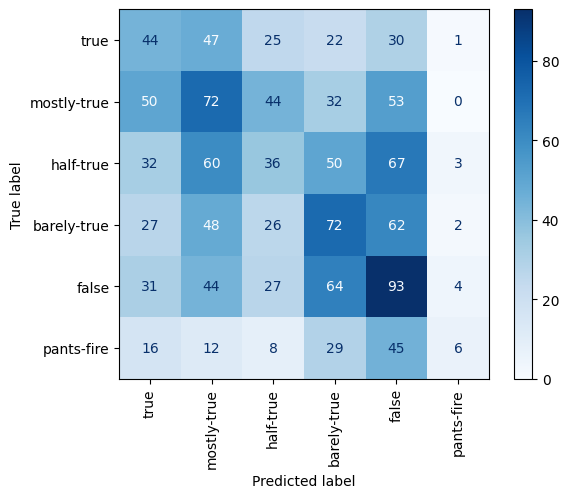

In [ ]:
plot_confusion_matrix(true, pred, classes=id2label.values())